In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

c:\Users\takat\anaconda3\envs\tf\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Load the data
file_path = '../../../Dataset/DOGE-USD.csv'
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-01,0.006042,0.006320,0.005945,0.006215,0.006215,15518400
2018-03-02,0.006174,0.006232,0.005447,0.005482,0.005482,22498100
2018-03-03,0.005494,0.005756,0.005181,0.005301,0.005301,21545000
2018-03-04,0.005234,0.005502,0.005164,0.005502,0.005502,12133500
2018-03-05,0.005462,0.005535,0.005157,0.005218,0.005218,13627700


In [3]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    # 
    return df

               Close      MACD  Bollinger_Upper  Bollinger_Lower      MA26     EMA20
Date                                                                                
2018-10-02  0.005824  0.000241         0.006478         0.005382  0.005966  0.005739
2018-10-03  0.005704  0.000213         0.006358         0.005417  0.005981  0.005736
2018-10-04  0.005645  0.000183         0.006322         0.005400  0.005979  0.005727
2018-10-05  0.005669  0.000159         0.006282         0.005391  0.005973  0.005722
2018-10-06  0.005545  0.000129         0.006110         0.005464  0.005921  0.005705


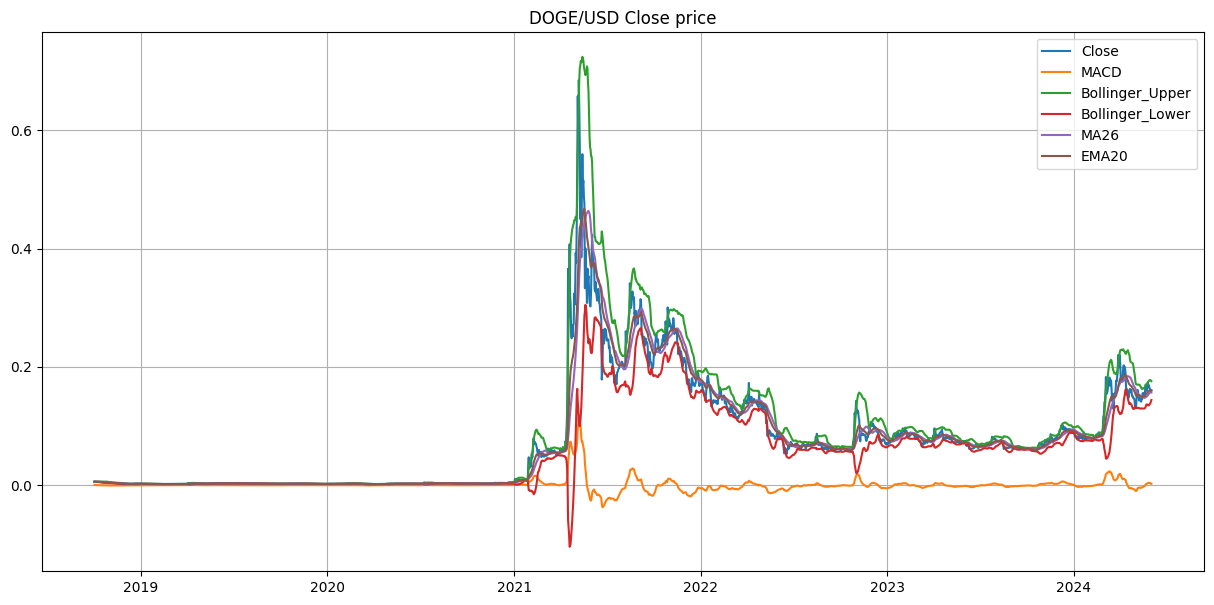

In [4]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]
# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()
# Filter the data to the list of FEATURES
df_filtered = df_filtered.dropna()
# Filter the data to the list of FEATURES
print(df_filtered.head().to_string())  
    

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('DOGE/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()

In [5]:
# Training and Test dataset
test_size = 0.3
train_size = int(len(df_filtered) * (1 - test_size))
train, test = df_filtered.iloc[0:train_size], df_filtered.iloc[train_size:len(df_filtered)]

In [6]:
X_train = train.drop('Close', axis=1)
y_train = train['Close']

X_test = test.drop('Close', axis=1)
y_test = test['Close']


In [7]:
# LightGBM
# LightGBM regression model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1449, number of used features: 5
[LightGBM] [Info] Start training from score 0.072068


LGBMRegressor()

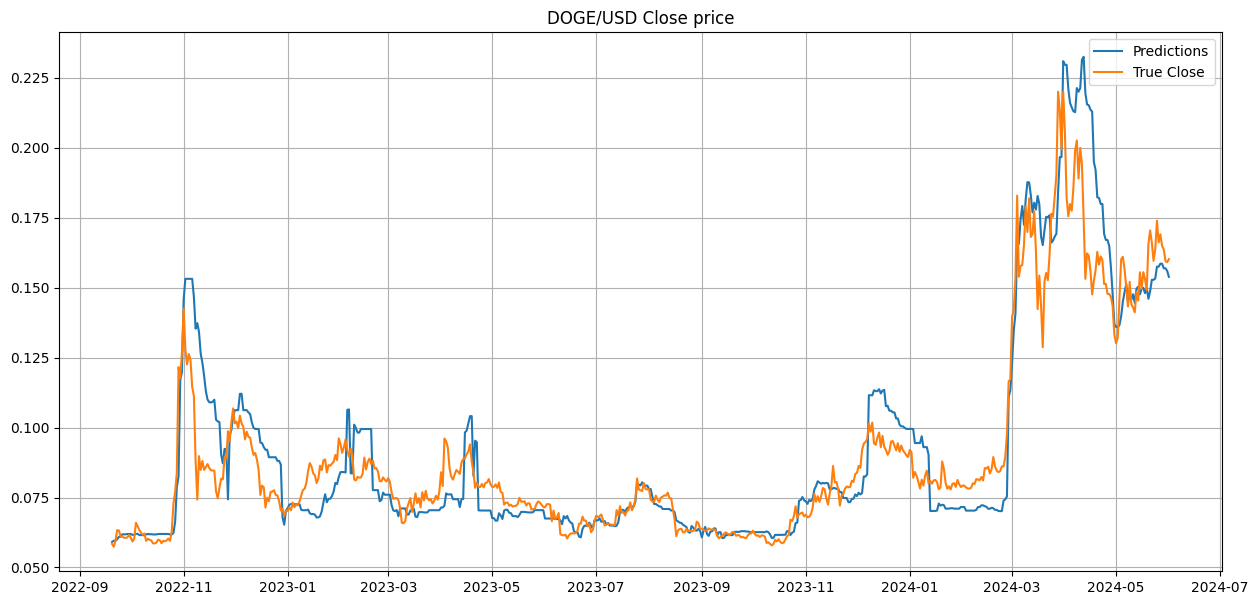

In [8]:
# Make predictions for validation and test sets
test_preds = model.predict(X_test)

# plot the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test_preds, label='Predictions')
plt.plot(test.index, test['Close'], label='True Close')
plt.title('DOGE/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [9]:
# Create function to forecast next x days
def forecast_next_x_days(df, num_days, best_model):

    print(f"Forecasting for day {num_days}")
    # Predict 1 day ahead and use the forecasted value to create features for the next day
    df_forecast = df.copy()
    for i in range(num_days):
        # Create the forecast's exogenous variables
        lag_feature_input = df_forecast.iloc[-1].drop('Close').copy()
        print(f"Forecasting for day {i+1}")
        forecast_1_ahead = best_model.predict(lag_feature_input.values.reshape(1, -1))
        print(f"Forecasted value for day {i+1}: {forecast_1_ahead[0]}") 
        # Append the forecasted value to the dataset 
        lag_feature_input['Close'] = forecast_1_ahead[0]
        df_forecast_extend = pd.DataFrame([lag_feature_input], columns=df_forecast.columns)
        df_forecast = pd.concat([df_forecast, df_forecast_extend], axis=0)
        df_forecast.index = pd.date_range(start=df_forecast.index.min(), periods=len(df_forecast))
        # Create the features for the next day
        df_forecast = createFeatures(df_forecast)
        # Filter the data to the list of FEATURES
        df_forecast = df_forecast[FEATURES].copy()

        
    return df_forecast[-num_days:]

In [10]:
fc_90_day = forecast_next_x_days(df_filtered, 90, model)
fc_60_day = forecast_next_x_days(df_filtered, 60, model)
fc_30_day = forecast_next_x_days(df_filtered, 30, model)

Forecasting for day 90
Forecasting for day 1
Forecasted value for day 1: 0.15388401414306618
Forecasting for day 2
Forecasted value for day 2: 0.153574161079462
Forecasting for day 3
Forecasted value for day 3: 0.1531987748119588
Forecasting for day 4
Forecasted value for day 4: 0.15378316585476884
Forecasting for day 5
Forecasted value for day 5: 0.150906767252878
Forecasting for day 6
Forecasted value for day 6: 0.150906767252878
Forecasting for day 7
Forecasted value for day 7: 0.15120519376011318
Forecasting for day 8
Forecasted value for day 8: 0.1514992941136075
Forecasting for day 9
Forecasted value for day 9: 0.1514992941136075
Forecasting for day 10
Forecasted value for day 10: 0.1514992941136075
Forecasting for day 11
Forecasted value for day 11: 0.1514992941136075
Forecasting for day 12
Forecasted value for day 12: 0.15276274979786802
Forecasting for day 13
Forecasted value for day 13: 0.15276274979786802
Forecasting for day 14
Forecasted value for day 14: 0.1482388940985756

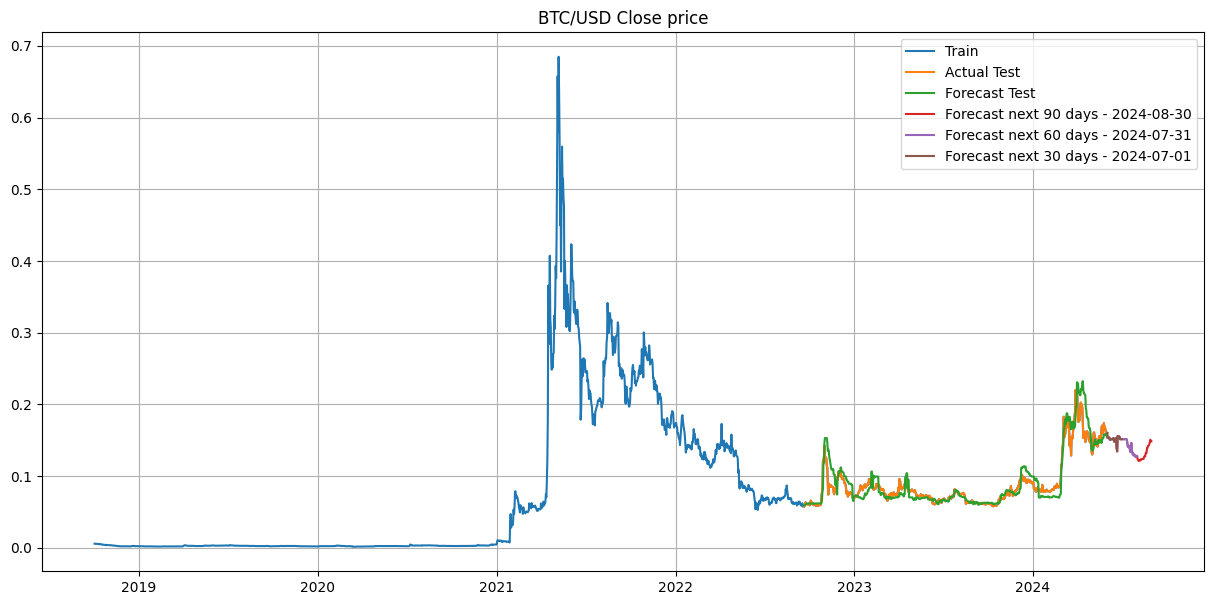

In [11]:
df_forecast_90 = fc_90_day.copy()
df_forecast_90.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_90))

df_forecast_60 = fc_60_day.copy()
df_forecast_60.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_60))

df_forecast_30 = fc_30_day.copy()
df_forecast_30.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_30))

# Label the forecasted data
forecast_30_label = f"Forecast next 30 days - " + df_forecast_30.index[-1].strftime("%Y-%m-%d")
forecast_60_label = f"Forecast next 60 days - " + df_forecast_60.index[-1].strftime("%Y-%m-%d")
forecast_90_label = f"Forecast next 90 days - " + df_forecast_90.index[-1].strftime("%Y-%m-%d")

# Add last day of original data to the forecasted data
df_forecast_30 = pd.concat([df_filtered.tail(1), df_forecast_30])
df_forecast_30.index = pd.date_range(start=df_filtered.index.max(), periods=len(df_forecast_30))

# Plot the overall with connection to forecast
plt.figure(figsize=(15, 7))
plt.plot(df_filtered['Close'], label='Train')
plt.plot(test.index, y_test, label='Actual Test')
plt.plot(test.index, test_preds, label='Forecast Test')
plt.plot(df_forecast_90.index, df_forecast_90['Close'], label=forecast_90_label)
plt.plot(df_forecast_60.index, df_forecast_60['Close'], label=forecast_60_label)
plt.plot(df_forecast_30.index, df_forecast_30['Close'], label=forecast_30_label)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [12]:
# Calculate the Model's RMSE, MAPE, and SMAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape


# Calculate the metrics for the test data
rmse, mape, smape = calculate_metrics(y_test, test_preds)
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")

RMSE: 0.01
MAPE: 9.26
SMAPE: 9.01
